In [1]:
import scipy
import numpy
from numpy import array
import matplotlib
import pandas 
import statsmodels
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
import os
from os import listdir
import re
import string
from nltk.corpus import stopwords
from collections import Counter
from scipy import stats as st
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

/Users/joysix/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8

In [3]:
os.chdir('/Users/joysix/Desktop')

In [4]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [5]:
# load one of the neg documents
filename = 'txt_sentoken/neg/cv000_29416.txt'
text = load_doc(filename)
# split into tokens by white space
tokens = text.split()
print(tokens)

['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', "what's", 'the', 'deal', '?', 'watch', 'the', 'movie', 'and', '"', 'sorta', '"', 'find', 'out', '.', '.', '.', 'critique', ':', 'a', 'mind-fuck', 'movie', 'for', 'the', 'teen', 'generation', 'that', 'touches', 'on', 'a', 'very', 'cool', 'idea', ',', 'but', 'presents', 'it', 'in', 'a', 'very', 'bad', 'package', '.', 'which', 'is', 'what', 'makes', 'this', 'review', 'an', 'even', 'harder', 'one', 'to', 'write', ',', 'since', 'i', 'generally', 'applaud', 'films', 'which', 'attempt', 'to', 'break', 'the', 'mold', ',', 'mess', 'with', 'your', 'head', 'and', 'such', '(', 'lost', 'highway', '&', 'memento', ')', ',', 'but', 'there', 'are', 'good', 'and', 'bad', 'ways', 'of'

# Data Wrangling

Will first test the clean_doc function on just one of the negative reviews. The clean_doc function should:

    1) Split tokens on white space.
    2) Remove all punctuation from words.
    3) Remove all words that are not purely comprised of alphabetical characters.
    4) Remove all words that are known stop words.
    5) Remove all words that have a length ≤ 1 character.

In [6]:
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load that same neg document from previously, but now clean
filename = 'txt_sentoken/neg/cv000_29416.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens)

['plot', 'two', 'teen', 'couples', 'go', 'church', 'party', 'drink', 'drive', 'get', 'accident', 'one', 'guys', 'dies', 'girlfriend', 'continues', 'see', 'life', 'nightmares', 'whats', 'deal', 'watch', 'movie', 'sorta', 'find', 'critique', 'mindfuck', 'movie', 'teen', 'generation', 'touches', 'cool', 'idea', 'presents', 'bad', 'package', 'makes', 'review', 'even', 'harder', 'one', 'write', 'since', 'generally', 'applaud', 'films', 'attempt', 'break', 'mold', 'mess', 'head', 'lost', 'highway', 'memento', 'good', 'bad', 'ways', 'making', 'types', 'films', 'folks', 'didnt', 'snag', 'one', 'correctly', 'seem', 'taken', 'pretty', 'neat', 'concept', 'executed', 'terribly', 'problems', 'movie', 'well', 'main', 'problem', 'simply', 'jumbled', 'starts', 'normal', 'downshifts', 'fantasy', 'world', 'audience', 'member', 'idea', 'whats', 'going', 'dreams', 'characters', 'coming', 'back', 'dead', 'others', 'look', 'like', 'dead', 'strange', 'apparitions', 'disappearances', 'looooot', 'chase', 'scen

In [7]:
# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

In [8]:
# load all docs in a directory
def process_docs(directory, vocab):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        add_doc_to_vocab(path, vocab)

In [9]:
# define neg vocab
vocab_neg = Counter()
# add all docs to vocab
process_docs('txt_sentoken/neg', vocab_neg)
# print the size of the vocab
print(len(vocab_neg))
# print the top words in the vocab
print(vocab_neg.most_common(20))

32010
[('film', 3994), ('movie', 3048), ('one', 2617), ('like', 1835), ('even', 1381), ('good', 1127), ('time', 1112), ('would', 1049), ('get', 1037), ('bad', 1019), ('much', 997), ('characters', 909), ('films', 903), ('story', 903), ('character', 893), ('plot', 876), ('two', 865), ('make', 818), ('first', 805), ('really', 787)]


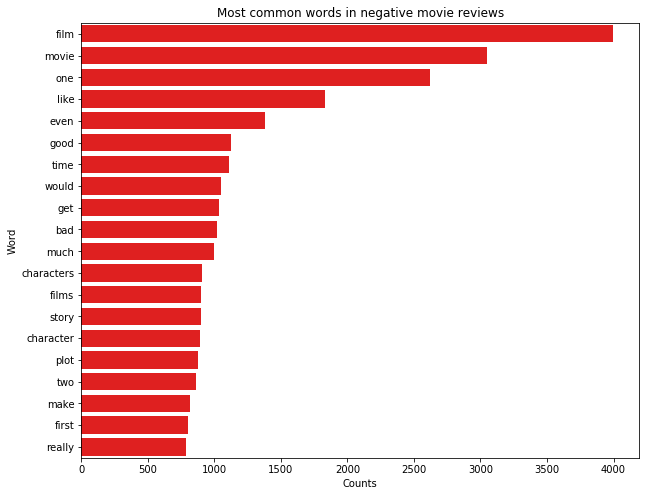

In [10]:
y, x = zip(*vocab_neg.most_common(20))
ax = sns.barplot(x, y, color='red')
ax.set(xlabel='Counts', ylabel='Word')
_=ax.set_title('Most common words in negative movie reviews')

In [11]:
# define pos vocab
vocab_pos = Counter()
# add all docs to vocab
process_docs('txt_sentoken/pos', vocab_pos)
# print the size of the vocab
print(len(vocab_pos))
# print the top words in the vocab
print(vocab_pos.most_common(20))

34218
[('film', 4866), ('one', 2904), ('movie', 2392), ('like', 1718), ('story', 1215), ('also', 1200), ('films', 1199), ('good', 1193), ('even', 1174), ('time', 1171), ('characters', 1038), ('much', 1027), ('character', 1013), ('would', 993), ('life', 984), ('well', 968), ('first', 963), ('two', 960), ('see', 954), ('way', 915)]


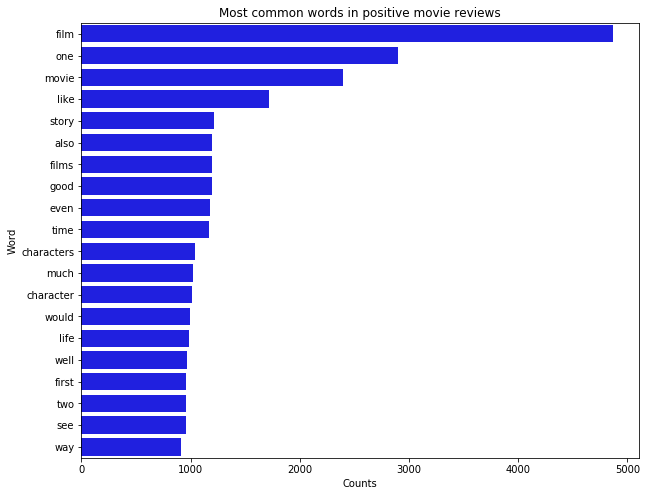

In [12]:
y, x = zip(*vocab_pos.most_common(20))
ax = sns.barplot(x, y, color='blue')
ax.set(xlabel='Counts', ylabel='Word')
_=ax.set_title('Most common words in positive movie reviews')

In [13]:
# load all docs in a directory and hold out 10% for testing. Will come in handy later..
def process_all_docs(directory, vocab):
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if filename.startswith('cv9'): continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # add doc to vocab
        add_doc_to_vocab(path, vocab)

In [14]:
# define vocab for training set 
vocab = Counter()
# add all docs to vocab
process_all_docs('txt_sentoken/neg', vocab)
process_all_docs('txt_sentoken/pos', vocab)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(20))

44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511)]


In [15]:
# keep tokens in neg dataset with a min occurrence
min_occurrence = 2
tokens_neg = [k for k,c in vocab_neg.items() if c >= min_occurrence]
print(len(tokens_neg))

18137


In [16]:
# keep tokens in pos dataset with a min occurrence
min_occurrence = 2
tokens_pos = [k for k,c in vocab_pos.items() if c >= min_occurrence]
print(len(tokens_pos))

19578


In [17]:
# keep tokens in training set with a min occurrence
min_occurrence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurrence]
print(len(tokens))

25767


In [18]:
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

In [19]:
# save pos and neg tokens to seperate vocabulary files
save_list(tokens_neg, 'vocab_neg.txt')
save_list(tokens_pos, 'vocab_pos.txt')

In [20]:
# save training tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

In [21]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [22]:
# load all docs in a directory
def process_neg_docs(directory, vocab_neg):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab_neg)
        # add to list
        lines.append(line)
    return lines

In [23]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [24]:
# load and clean neg dataset
def load_neg_clean_dataset(vocab_neg):
    # load documents
    neg = process_neg_docs('txt_sentoken/neg', vocab_neg)
    return neg

In [25]:
# load neg vocabulary
vocab_filename = 'vocab_neg.txt'
vocab_neg = load_doc(vocab_filename)
vocab_neg = vocab_neg.split()

In [26]:
# load all neg reviews
neg_docs = load_neg_clean_dataset(vocab_neg)

In [27]:
# create the tokenizer
tokenizer = create_tokenizer(neg_docs)
# encode data
neg_words = tokenizer.texts_to_sequences(neg_docs)

## Negative Review Descriptive Statistics

   As expected, 1000 reviews were analyzed. One review actually only had 7 words which seems kind of funny, I'm guessing the critic really didn't like that movie. 

NEGATIVE REVIEW LENGTH: 
  Number: 1000 documents 
  Min: 7 words 
  Max: 965 words 
  Mean: 317.57 words 
  Standard deviation: 131.50 words 
  Median: 301.50 words 


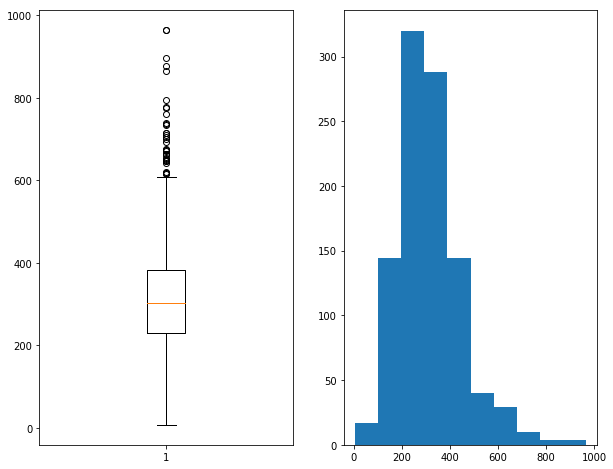

In [28]:
# Summarize review length
print("NEGATIVE REVIEW LENGTH: ")
result_neg = [len(x) for x in neg_words]
print("  Number: %d documents " % len(neg_words))
print("  Min: %d words " % (numpy.min(result_neg)))
print("  Max: %d words " % (numpy.max(result_neg)))
print("  Mean: %.2f words " % (numpy.mean(result_neg))) 
print("  Standard deviation: %.2f words " % (numpy.std(result_neg)))
print("  Median: %.2f words " % (numpy.median(result_neg)))
# plot review length as a boxplot
pyplot.subplot(121)
pyplot.boxplot(result_neg)
pyplot.subplot(122)
_=pyplot.hist(result_neg)

In [29]:
# load all docs in a directory
def process_pos_docs(directory, vocab_pos):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab_pos)
        # add to list
        lines.append(line)
    return lines

In [30]:
# load and clean pos dataset
def load_pos_clean_dataset(vocab_pos):
    # load documents
    pos = process_pos_docs('txt_sentoken/pos', vocab_pos)
    return pos

In [31]:
# load pos vocabulary
vocab_filename = 'vocab_pos.txt'
vocab_pos = load_doc(vocab_filename)
vocab_pos = vocab_pos.split()

In [32]:
# load all pos reviews
pos_docs = load_pos_clean_dataset(vocab_pos)

In [33]:
# create the tokenizer
tokenizer = create_tokenizer(pos_docs)
# encode data
pos_words = tokenizer.texts_to_sequences(pos_docs)

## Positive Review Descriptive Statistics

POSITIVE REVIEW LENGTH: 
  Number: 1000 documents 
  Min: 63 words 
  Max: 1299 words 
  Mean: 356.66 words 
  Standard deviation: 157.62 words 
  Median: 332.50 words 


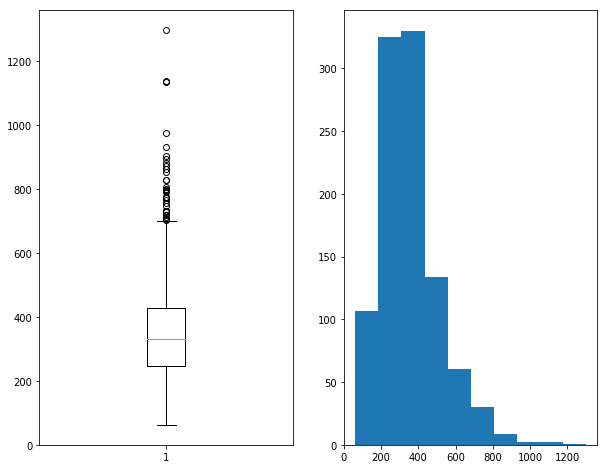

In [34]:
# Summarize review length
print("POSITIVE REVIEW LENGTH: ")
result_pos = [len(x) for x in pos_words]
print("  Number: %d documents " % len(pos_words))
print("  Min: %d words " % (numpy.min(result_pos)))
print("  Max: %d words " % (numpy.max(result_pos)))
print("  Mean: %.2f words " % (numpy.mean(result_pos))) 
print("  Standard deviation: %.2f words " % (numpy.std(result_pos)))
print("  Median: %.2f words " % (numpy.median(result_pos)))
# plot review length as a boxplot
pyplot.subplot(121)
pyplot.boxplot(result_pos)
pyplot.subplot(122)
_=pyplot.hist(result_pos)

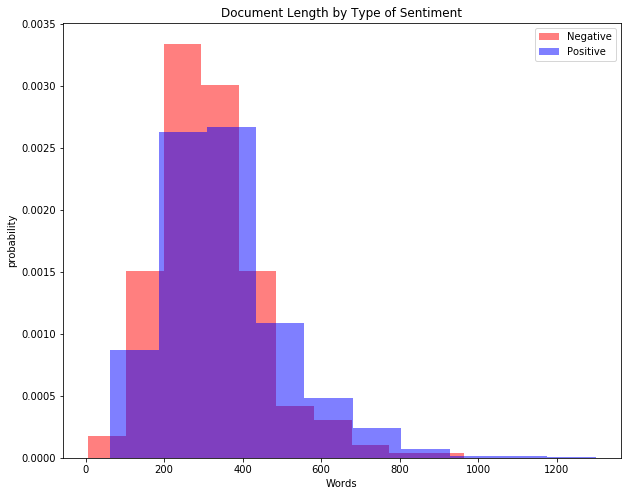

In [35]:
# use normed=True for relative histogram (vs. absolute)

pyplot.hist(result_neg, normed= True, color='r', alpha= 0.5, label="Negative")
pyplot.hist(result_pos, normed= True, color='b', alpha= 0.5, label="Positive")
pyplot.xlabel("Words")
pyplot.ylabel("probability")
pyplot.title("Document Length by Type of Sentiment")
_=pyplot.legend()

# Hypothesis Test

Compare the 2 independent means of the positive and negative review length.

H0: No difference between mu_pos and mu_neg, which is mu_pos - mu_neg = 0

Passes conditions of CLT with all observations being independent of one another and the number of observations is > 30 for both positive and negative reviews.

Calculate point estimate and standard error in order to calculate the z-score. Decided to use z-score instead of t-score, since there are > 30 observations for both positive and negative reviews

In [36]:
mu_pos = numpy.mean(result_pos)
mu_neg = numpy.mean(result_neg)
std_pos = numpy.std(result_pos)
std_neg = numpy.std(result_neg)
count_pos = len(pos_words)
count_neg = len(neg_words)

# Point Estimate
PE = round(mu_pos - mu_neg,2)

# Standard Error
SE =numpy.sqrt(((std_neg*std_neg)/count_neg)+((std_pos*std_pos)/count_pos) )

# Z-score:
Z= PE/SE
print("Z-score: ")
Z

Z-score: 


6.021933563892945

With a p-value of < 0.05, reject H0 (No difference between mu_pos and mu_neg). The mean positive and negative review length difference is statistically significant. Reviews that have positive sentiment are more wordy and perhaps it's because people are more excited about a good movie and like to talk more about it, than compared to a bad movie with a negative sentiment??

In [37]:
print("P-value: ")
st.norm.sf(abs(Z))

P-value: 


8.617282032176605e-10

## Machine Learning

In [38]:
# turn a doc into clean tokens
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens

In [39]:
# load all docs in a directory
def process_docs(directory, vocab, is_train):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'): continue
        if not is_train and not filename.startswith('cv9'): continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

In [40]:
# load and clean a dataset
def load_clean_dataset(vocab, is_train):
    # load documents
    neg = process_docs('txt_sentoken/neg', vocab, is_train)
    pos = process_docs('txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

In [41]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [42]:
# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

In [43]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, max_length, model):
    # clean review
    line = clean_doc(review, vocab)
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [44]:
# define the model
def define_model(vocab_size, max_length):
    # define network
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [45]:
# load vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()

In [46]:
# load training reviews
train_docs, ytrain = load_clean_dataset(vocab, True)

In [47]:
# load test reviews
test_docs, ytest = load_clean_dataset(vocab, False)

In [48]:
# Summarize number of classes
print("Classes: ")
print(numpy.unique(ytrain))

Classes: 
[0 1]


In [49]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [50]:
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 25768


In [51]:
# calculate the maximum sequence length
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)

Maximum length: 1317


In [52]:
# encode data
Xtrain = encode_docs(tokenizer, max_length, train_docs)
Xtest = encode_docs(tokenizer, max_length, test_docs)
print(Xtrain.shape, Xtest.shape)

(1800, 1317) (200, 1317)


In [53]:
# define model
model = define_model(vocab_size, max_length)

In [54]:
# summarize defined model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1317, 100)         2576800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1310, 32)          25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 655, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20960)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                209610    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,812,053
Trainable params: 2,812,053
Non-trainable params: 0
_________________________________________________________________


In [55]:
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)

Epoch 1/10
 - 50s - loss: 0.6903 - acc: 0.5244
Epoch 2/10
 - 48s - loss: 0.5483 - acc: 0.7461
Epoch 3/10
 - 47s - loss: 0.1131 - acc: 0.9761
Epoch 4/10
 - 46s - loss: 0.0067 - acc: 1.0000
Epoch 5/10
 - 49s - loss: 0.0017 - acc: 1.0000
Epoch 6/10
 - 46s - loss: 9.9573e-04 - acc: 1.0000
Epoch 7/10
 - 47s - loss: 7.3594e-04 - acc: 1.0000
Epoch 8/10
 - 46s - loss: 5.8793e-04 - acc: 1.0000
Epoch 9/10
 - 46s - loss: 4.8603e-04 - acc: 1.0000
Epoch 10/10
 - 46s - loss: 3.8043e-04 - acc: 1.0000


In [56]:
# save the model
model.save('model.h5')

In [57]:
# load the model
model = load_model('model.h5')

In [58]:
# evaluate model on training dataset
_, acc = model.evaluate(Xtrain, ytrain, verbose=0)
print('Train Accuracy: %.2f' % (acc*100))
# evaluate model on test dataset
_, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %.2f' % (acc*100))
# test positive text
text = 'Everyone will enjoy this amazing film. It was so exciting and thrilling. I love it, recommended! Thumbs up!'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks. Put me to sleep. Boring'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Train Accuracy: 100.00
Test Accuracy: 86.00
Review: [Everyone will enjoy this amazing film. It was so exciting and thrilling. I love it, recommended! Thumbs up!]
Sentiment: POSITIVE (52.124%)
Review: [This is a bad movie. Do not watch it. It sucks. Put me to sleep. Boring]
Sentiment: NEGATIVE (66.410%)
